In [3]:
# Install required packages
!pip install -q transformers datasets sentencepiece
!pip install -q pytorch-lightning wandb
!pip install -q donut-python

# !huggingface-cli login this shouldh be done from the terminal

In [3]:
from transformers import DonutProcessor, VisionEncoderDecoderModel

processor = DonutProcessor.from_pretrained("Jac-Zac/thesis_test_donut")
model = VisionEncoderDecoderModel.from_pretrained("Jac-Zac/thesis_test_donut")

Resolving data files:   0%|          | 0/1462 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/184 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/184 [00:00<?, ?it/s]

Found cached dataset imagefolder (/Users/jaczac/.cache/huggingface/datasets/imagefolder/img_resized-45137e88c492ea73/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/5 [00:00<?, ?it/s]

Sample 1
Ground truth: {'Nome_verbatim': 'Dryopteris linnaeana ', 'Nome_floritaly': 'Dryopteris linnaeana C.Chr', 'Luogo_Raccolta': 'Caravanche', 'Altitudine': ' ', 'Giorno': 15, 'Mese': 7.0, 'Anno': 1952.0}
Prediction: {'Nome_verbatim': 'Dryopteris linnaeana', 'Nome_floritaly': 'Dryopteris linnaeana C.Chr', 'Luogo_Raccolta': 'Caravanche', 'Altitudine': '', 'Giorno': '15', 'Mese': '7.0', 'Anno': '1952.0'}
Score: 0.9864864864864865


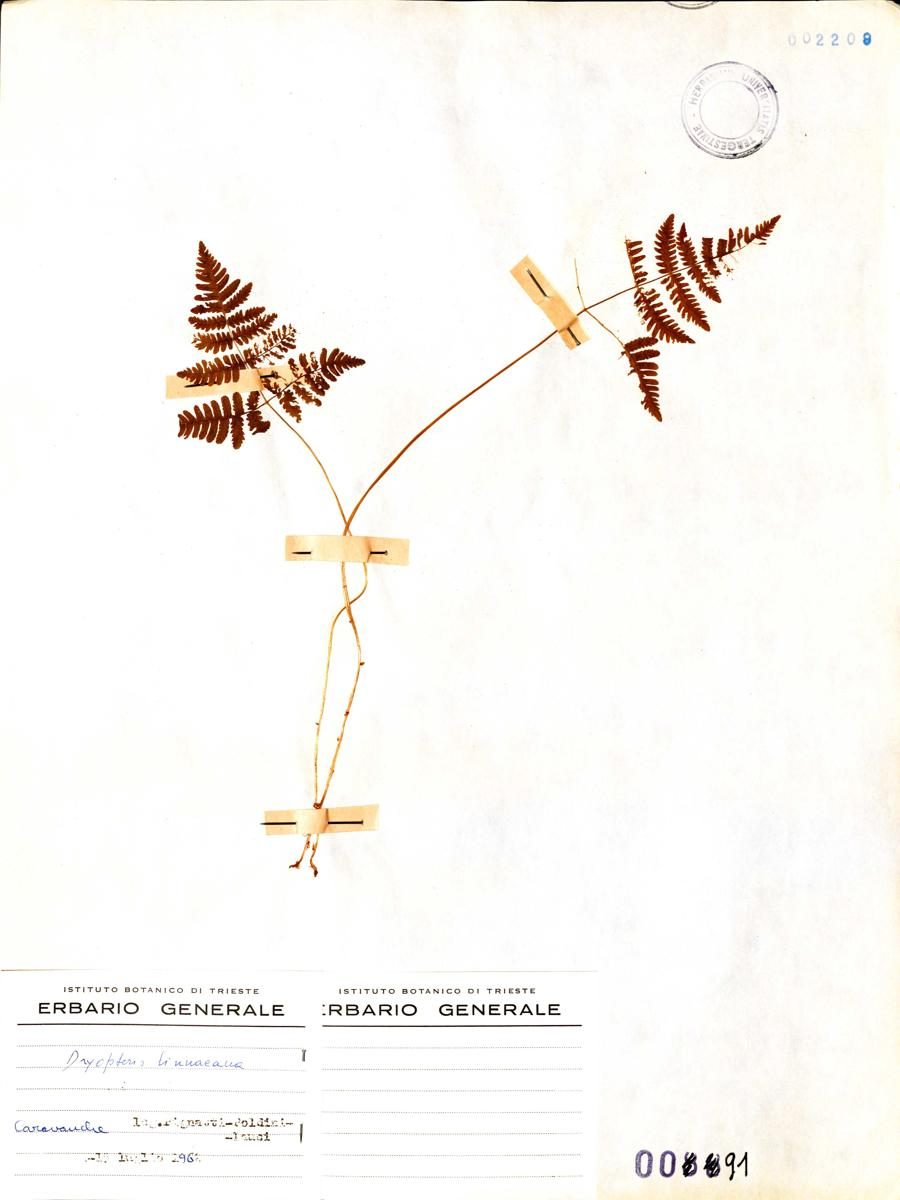

Sample 2
Ground truth: {'Nome_verbatim': 'Equisetum fluviatile', 'Nome_floritaly': 'Equisetum fluviatile L.\n', 'Luogo_Raccolta': 'Neeracher Riet(area protetta in Svizzera?)', 'Altitudine': ' ', 'Giorno': 11, 'Mese': 7.0, 'Anno': 1972.0}
Prediction: {'Nome_verbatim': 'Equisetum fluviatile', 'Nome_floritaly': 'Equisetum fluviatile L.', 'Luogo_Raccolta': 'Neeracher Riet(area protetta in Svizzera?)', 'Altitudine': '', 'Giorno': '11', 'Mese': '7.0', 'Anno': '1972.0'}
Score: 0.9902912621359223


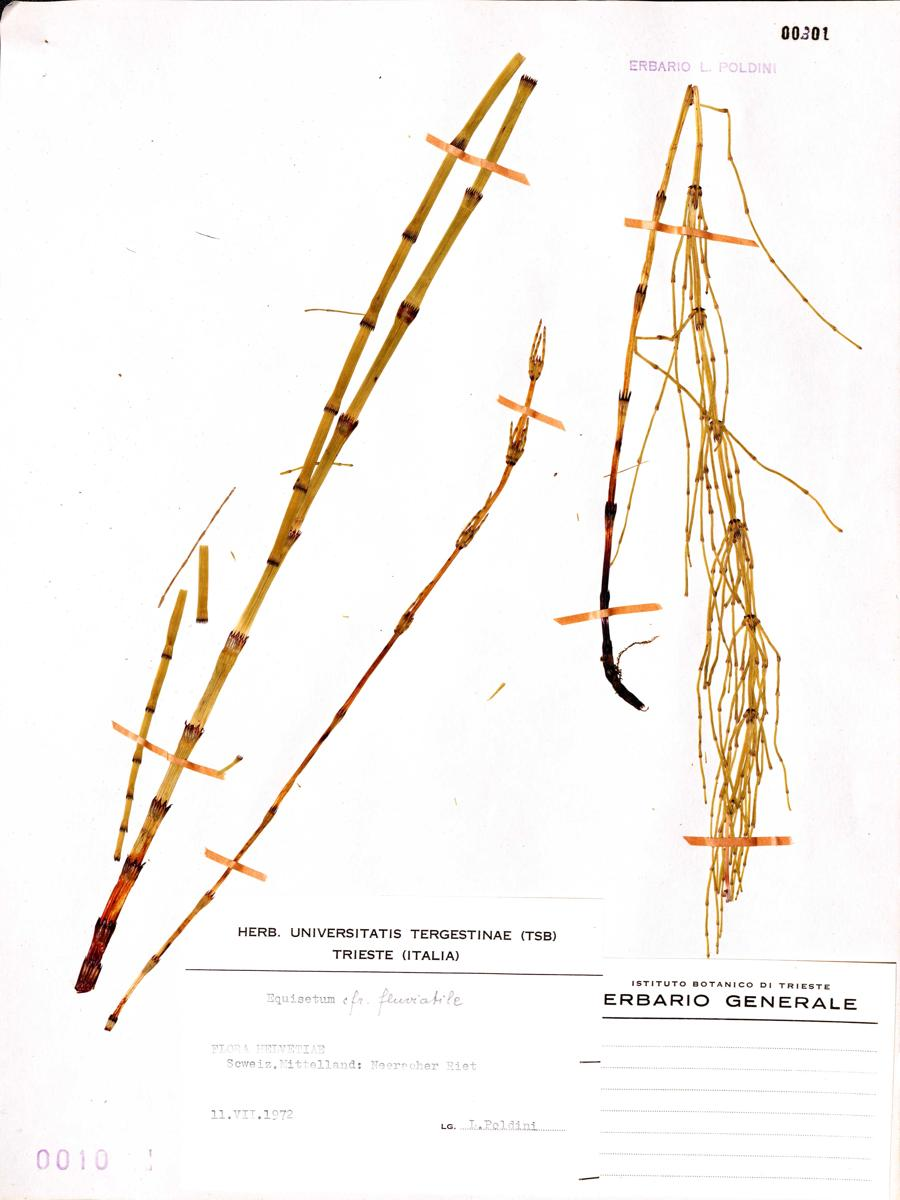

Sample 3
Ground truth: {'Nome_verbatim': 'Lycopodium annotinum L.', 'Nome_floritaly': 'Spinulum annotinum (L.) A.Haines subsp. annotinum\n', 'Luogo_Raccolta': 'Casera Nauleni,passo del Pura, Alpi Carniche, provincia di Udine', 'Altitudine': 1639, 'Giorno': 21, 'Mese': 8.0, 'Anno': 1974.0}
Prediction: {'Nome_verbatim': 'Lycopodium annotinum', 'Nome_floritaly': 'Spinulum annotinum (L.) A.Haines subsp. annotinum', 'Luogo_Raccolta': 'Malga Meledni, Appzzo', 'Altitudine': '450', 'Giorno': '2', 'Mese': '8.0', 'Anno': '1972.0'}
Score: 0.6075949367088608


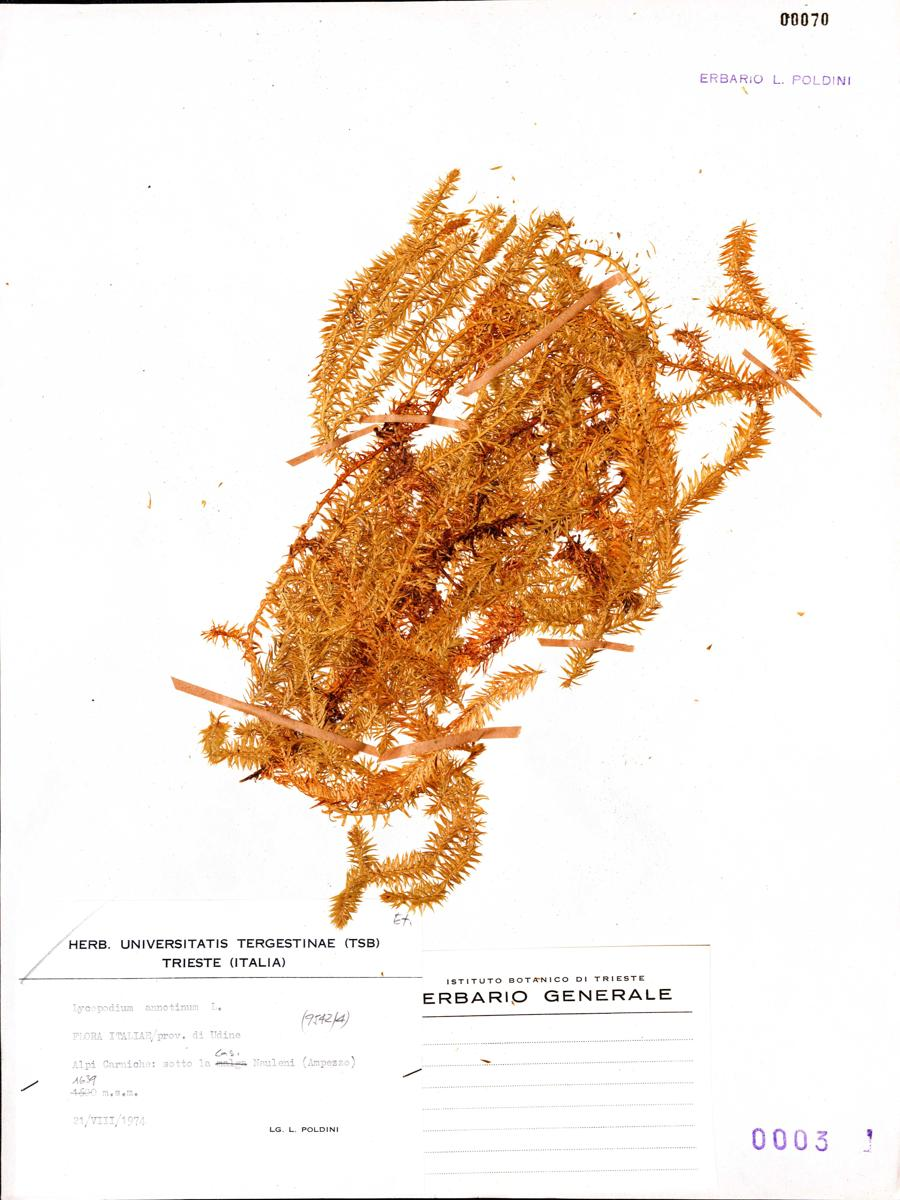

Sample 4
Ground truth: {'Nome_verbatim': 'Asplenium onopteris L', 'Nome_floritaly': 'Asplenium onopteris L.\n', 'Luogo_Raccolta': 'Valle del Biois', 'Altitudine': 150, 'Giorno': 19, 'Mese': 5.0, 'Anno': 1957.0}
Prediction: {'Nome_verbatim': 'Asplenium onopteris L', 'Nome_floritaly': 'Asplenium onopteris L.', 'Luogo_Raccolta': 'Valle del Biois', 'Altitudine': '150', 'Giorno': '19', 'Mese': '7.0', 'Anno': '1957.0'}
Score: 0.9873417721518988


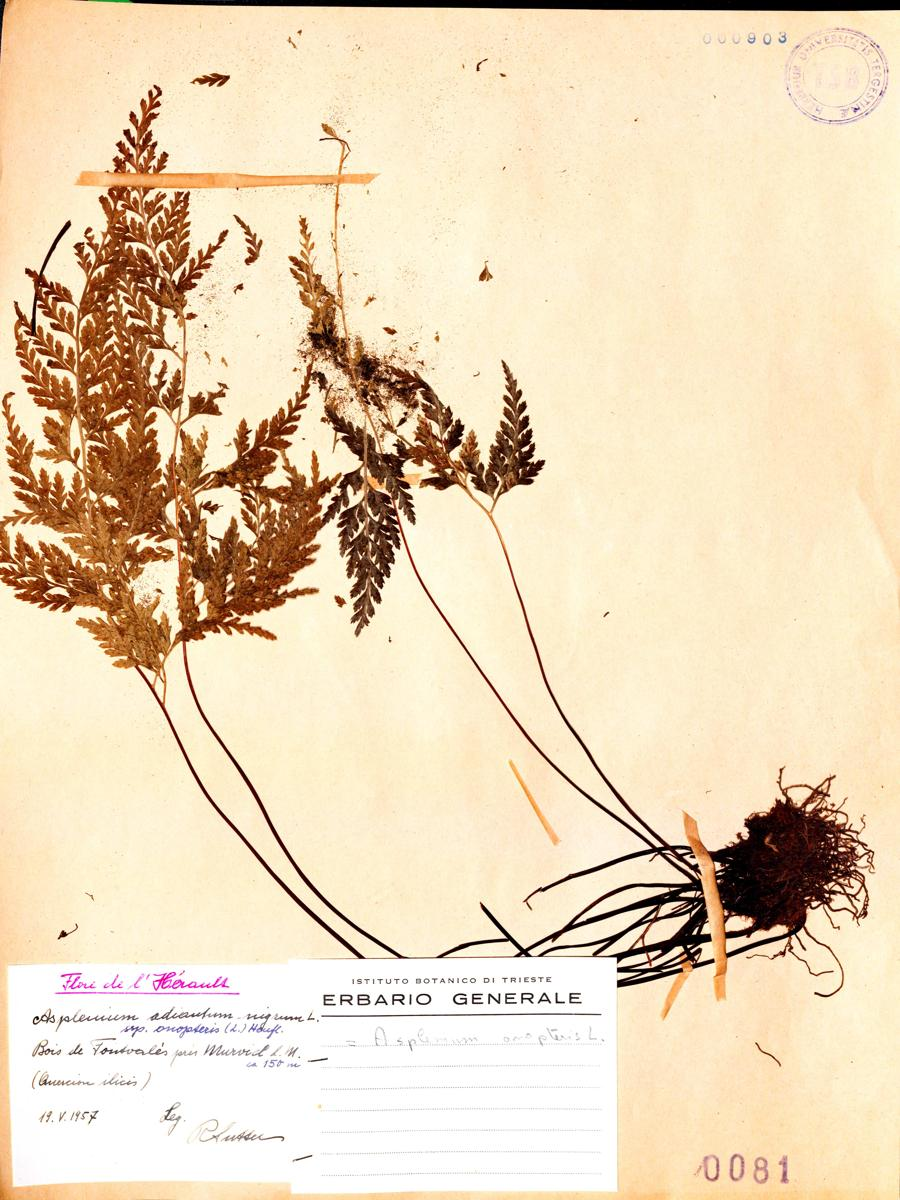

Sample 5
Ground truth: {'Nome_verbatim': 'Phyllitis scolopendrium (L.) New', 'Nome_floritaly': 'Asplenium scolopendrium L. subsp. scolopendrium\n', 'Luogo_Raccolta': 'Ojców', 'Altitudine': 400, 'Giorno': 22, 'Mese': 5.0, 'Anno': 1964.0}
Prediction: {'Nome_verbatim': 'Phyllitis scolopendrium (L.) New', 'Nome_floritaly': 'Asplenium scolopendrium L. subsp. scolopendrium', 'Luogo_Raccolta': 'Ojców', 'Altitudine': '400', 'Giorno': '22', 'Mese': '5.0', 'Anno': '1964.0'}
Score: 1.0


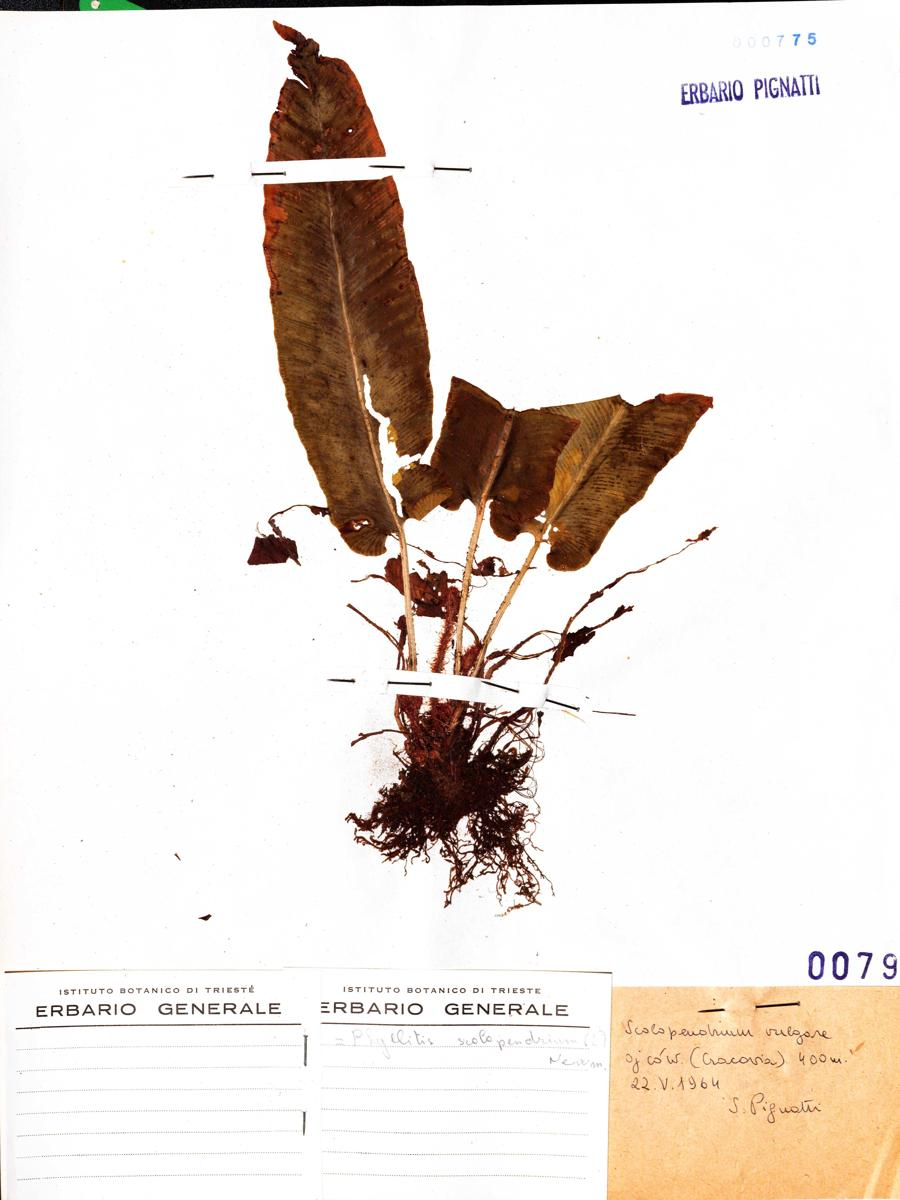

{'accuracies': [0.9864864864864865, 0.9902912621359223, 0.6075949367088608, 0.9873417721518988, 1.0], 'mean_accuracy': 0.9143428914966336} length : 5


In [4]:
import re
import json
import torch
from tqdm.auto import tqdm
import numpy as np
import random
from PIL import Image

from donut import JSONParseEvaluator
from datasets import load_dataset

# Set the random seed
random.seed(42)

device = "cpu" 
# device = "mps" if torch.backends.mps.is_available() else "cpu" # In the future

model.eval()
model.to(device)

output_list = []
accs = []

image_path = "/Users/jaczac/Github/Thesis/donut_example/copy/img_resized"

dataset = load_dataset(image_path, split="test")

# Convert dataset to list
dataset_list = list(dataset)

# Randomly select 5 samples
random_samples = random.sample(dataset_list, 5)

for idx, sample in tqdm(enumerate(random_samples), total=len(random_samples)):
    # prepare encoder inputs
    pixel_values = processor(sample["image"].convert("RGB"), return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)
    # prepare decoder inputs
    task_prompt = "<s_herbarium>"
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids
    decoder_input_ids = decoder_input_ids.to(device)
    
    # autoregressively generate sequence
    outputs = model.generate(
            pixel_values,
            decoder_input_ids=decoder_input_ids,
            max_length=model.decoder.config.max_position_embeddings,
            early_stopping=True,
            pad_token_id=processor.tokenizer.pad_token_id,
            eos_token_id=processor.tokenizer.eos_token_id,
            use_cache=True,
            num_beams=1,
            bad_words_ids=[[processor.tokenizer.unk_token_id]],
            return_dict_in_generate=True,
        )

    # turn into JSON
    seq = processor.batch_decode(outputs.sequences)[0]
    seq = seq.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
    seq = re.sub(r"<.*?>", "", seq, count=1).strip()  # remove first task start token
    seq = processor.token2json(seq)

    ground_truth = json.loads(sample["ground_truth"])
    evaluator = JSONParseEvaluator()
    score = evaluator.cal_acc(seq, ground_truth)

    accs.append(score)
    output_list.append(seq)

    # Print ground truth and prediction for each sample
    print("Sample", idx+1)
    print("Ground truth:", ground_truth)
    print("Prediction:", seq)
    print("Score:", score)
    width, height = sample["image"].size
    display(sample["image"])

# Calculate and print mean accuracy
scores = {"accuracies": accs, "mean_accuracy": np.mean(accs)}
print(scores, f"length : {len(accs)}")

In [22]:
print("Mean accuracy:", np.mean(accs))

Mean accuracy: 0.7543237699895771
